# Proyecto Diabetes

## Definición del problema

Determinar si el paciente presentará en su examen de diagnóstico una respuesta positiva a la diabetes según una serie de variables medidas.

In [885]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import uniform, randint

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier 

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import matplotlib.pyplot as plt 
import plotly.express as px

## Obtención de la data

### Descripción de variables

Todas las pacientes son mujeres y presentan las siguientes variables:

   1. **Embarazos**: Cantidad de embarazos.
   2. **Glucosa**:  Examen oral de tolerancia a la glucosa (mg/dL).
   3. **Presion_arterial**: Medición de la presión arterial diastólica (mm Hg).
   4. **Grosor_de_piel**: Grosor de piel del tricep (mm).
   5. **Insulina**: Medición de la insulina a las dos horas (mu U/ml).
   6. **IMC**: Indice de masa corporal (kg/(m)^2).
   7. **FDP**: Función diabetes pedigrí (FDP).
   8. **Edad**: Edad en años.
   9. **y**: Variable objetivo (0 o 1)
       1. Resultado positivo de diabetes
       2. Resultado negativo de diabetes
       
Todas las variables son numéricas a excepción de la variable objetivo **y**.

In [886]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'

variables = ['Embarazos', 'Glucosa', 'Presion_arterial', 'Grosor_de_piel', 
            'Insulina', 'IMC', 'FDP', 'Edad', 'y']

df = pd.read_csv(url, header=None, sep = ',', names = variables )
df

,Embarazos,Glucosa,Presion_arterial,Grosor_de_piel,Insulina,IMC,FDP,Edad,y
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Descripción básica de los datos

Se corrobora en primera instancia la cantidad de datos por variable y si existen nulos.

In [887]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Embarazos         768 non-null    int64  
 1   Glucosa           768 non-null    int64  
 2   Presion_arterial  768 non-null    int64  
 3   Grosor_de_piel    768 non-null    int64  
 4   Insulina          768 non-null    int64  
 5   IMC               768 non-null    float64
 6   FDP               768 non-null    float64
 7   Edad              768 non-null    int64  
 8   y                 768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Descripción estadística de los datos

Se observa en el resumen estadístico que existen algunas variables con valores minimos iguales a cero, lo cual es imposible. Esto indica que existen valores nulos que estan registrados como ceros.

Específicamente las variables que no pueden poseer un mínimo cero son:

1. Glucosa
2. Presion_arterial
3. Grosor_de_piel
4. Insulina
5. IMC

In [888]:
df.describe()

,Embarazos,Glucosa,Presion_arterial,Grosor_de_piel,Insulina,IMC,FDP,Edad,y
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Otra manera de observar los datos faltantes o mal ingresados es mediante histogramas, en donde es posible apreciar la presencia de valores que no corresponden a las respectivas variables. 

En las variables **Grosor_de_piel** e **Insulina** existen demasiados valores nulos en comparación con la cantidad total de datos, por lo que eliminarlos no es una opción factible. 

Por otra parte, la variable objetivo esta desbalanceada hacia el valor cero.

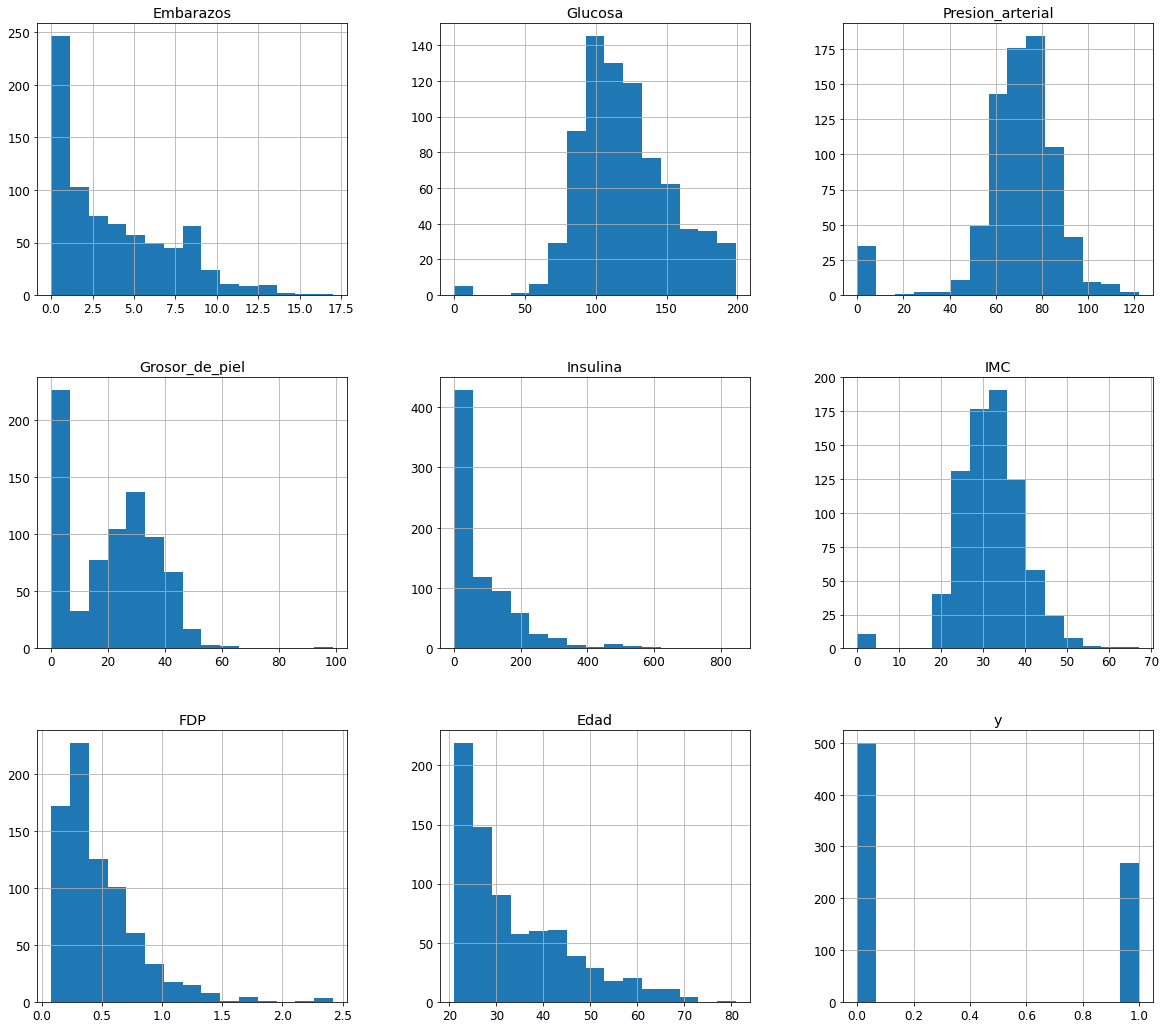

In [889]:
df.hist(bins=15, figsize=(20,18))
plt.show()

## Exploración de datos

### Valores vacíos, únicos, duplicados y nulos

Ninguna variable cuenta con valores vacíos.

In [890]:
(df == '').sum()

Embarazos           0
Glucosa             0
Presion_arterial    0
Grosor_de_piel      0
Insulina            0
IMC                 0
FDP                 0
Edad                0
y                   0
dtype: int64

No existen variables con un solo valor único, por lo que ninguna será descartada por este motivo.

In [891]:
df.nunique()

Embarazos            17
Glucosa             136
Presion_arterial     47
Grosor_de_piel       51
Insulina            186
IMC                 248
FDP                 517
Edad                 52
y                     2
dtype: int64

No existen valores duplicados.

In [892]:
df.duplicated().any()

False

Los datos que no corresponden a sus respectivas variables serán reemplazados por np.NaN para poder ser imputados más adelante.

In [893]:
#Variables con valores nulos
variable_nulos = ['Glucosa', 'Presion_arterial', 'Grosor_de_piel', 'Insulina', 'IMC']

#Los valores cero son reemplazados por np.NaN
df[variable_nulos] = df[variable_nulos].replace(0, np.NaN)

#Muestra la cantidad de valores nulos
df.isnull().sum()

Embarazos             0
Glucosa               5
Presion_arterial     35
Grosor_de_piel      227
Insulina            374
IMC                  11
FDP                   0
Edad                  0
y                     0
dtype: int64

La variable objetivo **y** es transformada al tipo categórico.

In [894]:
df.y = df.y.astype('category')

#### Supuesto

Se asume que las personas con similares características deberian poseer datos similares, por ello se utilizará el método de imputación de datos basado en el algoritmo kNN para llenar los datos faltantes, es decir, aquellos que no corresponden a un valor 0.

### Creación de datos de prueba

Antes de seguir realizando un análisis mas detallado de los datos se crea el conjunto de datos de entrenamiento y prueba para evitar la filtración de información de los datos de prueba hacia los modelos candidatos antes de tiempo. 

Se debe considerar que los datos de la variable objetivo **y** estan desbalanceados para el valor 0, que corresponden a un 65% del total, mientras que el 35% restante representa el valor 1. Por esta razón, para que el conjunto de prueba sea representativo serán separados de tal forma que estarán desbalanceados en la misma proporción que la data completa. Además se toma la decisión de separar los datos en un 20% para el conjunto de datos de prueba y un 80% para el conjunto de datos de entrenamiento.

In [895]:
print(df.y.value_counts()*100/df.y.count())

0    65.104167
1    34.895833
Name: y, dtype: float64


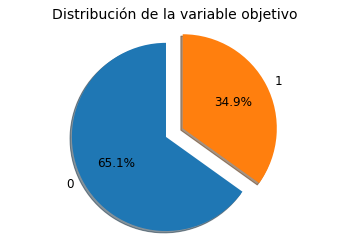

In [896]:
explode = (0.1, 0.1) 

plt.pie(df.y.value_counts(), explode=explode, labels=(0,1), autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Distribución de la variable objetivo', fontsize=14)
plt.show()

In [897]:
#Definición de variables
variables_pred = ['Embarazos', 'Glucosa', 'Presion_arterial', 'Grosor_de_piel', 
                  'Insulina', 'IMC', 'FDP', 'Edad']
variable_obj = 'y'

#Creación del conjunto de datos de entrenamiento y prueba
train, test = train_test_split(df, test_size=0.2, stratify = df.y, random_state = 5)

#Separación de las variables predictoras del objetivo
train_X = train[variables_pred]
train_y = train[variable_obj]
test_X = test[variables_pred] 
test_y = test[variable_obj]

In [898]:
train_X

,Embarazos,Glucosa,Presion_arterial,Grosor_de_piel,Insulina,IMC,FDP,Edad
291,0,107.0,62.0,30.0,74.0,36.6,0.757,25
652,5,123.0,74.0,40.0,77.0,34.1,0.269,28
244,2,146.0,76.0,35.0,194.0,38.2,0.329,29
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
633,1,128.0,82.0,17.0,183.0,27.5,0.115,22
...,...,...,...,...,...,...,...,...
535,4,132.0,NaN,NaN,NaN,32.9,0.302,23
384,1,125.0,70.0,24.0,110.0,24.3,0.221,25
533,6,91.0,NaN,NaN,NaN,29.8,0.501,31
672,10,68.0,106.0,23.0,49.0,35.5,0.285,47


In [899]:
print(train_y.value_counts()*100/train_y.count())

0    65.14658
1    34.85342
Name: y, dtype: float64


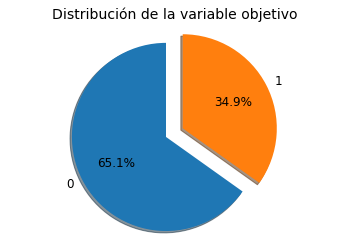

In [900]:
explode = (0.1, 0.1) 

plt.pie(train_y.value_counts(), explode=explode, labels=(0,1), autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal') 
plt.title('Distribución de la variable objetivo', fontsize=14)
plt.show()

In [901]:
print(test_y.value_counts()*100/test_y.count())

0    64.935065
1    35.064935
Name: y, dtype: float64


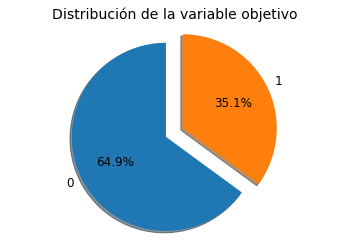

In [902]:
explode = (0.1, 0.1) 

plt.pie(test_y.value_counts(), explode=explode, labels=(0,1), autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Distribución de la variable objetivo', fontsize=14)
plt.show()

### Visualización de datos

El objetivo de la visualización de datos es extraer información sobre como están relacionadas las variables entre sí, tanto entre predictoras como entre predictoras y variable objetivo.

#### Distribución de los datos 

Para observar de mejor manera la distribución de los datos se desarollan nuevamente los histogramas de todas las variables del conjunto de datos de entrenamiento, sin considerar aquellos valores que no corresponden a ciertas variables.

Se puede extraer la siguiente información:

- Las variables **Embarazos**, **Insulina**, **FDP** y **Edad** presentan una distribución asímetrica hacia la izquierda.
- Las variables **Glucosa**, **Presion_arterial**, **Grosor_de_piel** e **IMC** presentan una distribución similar a la distribución normal.

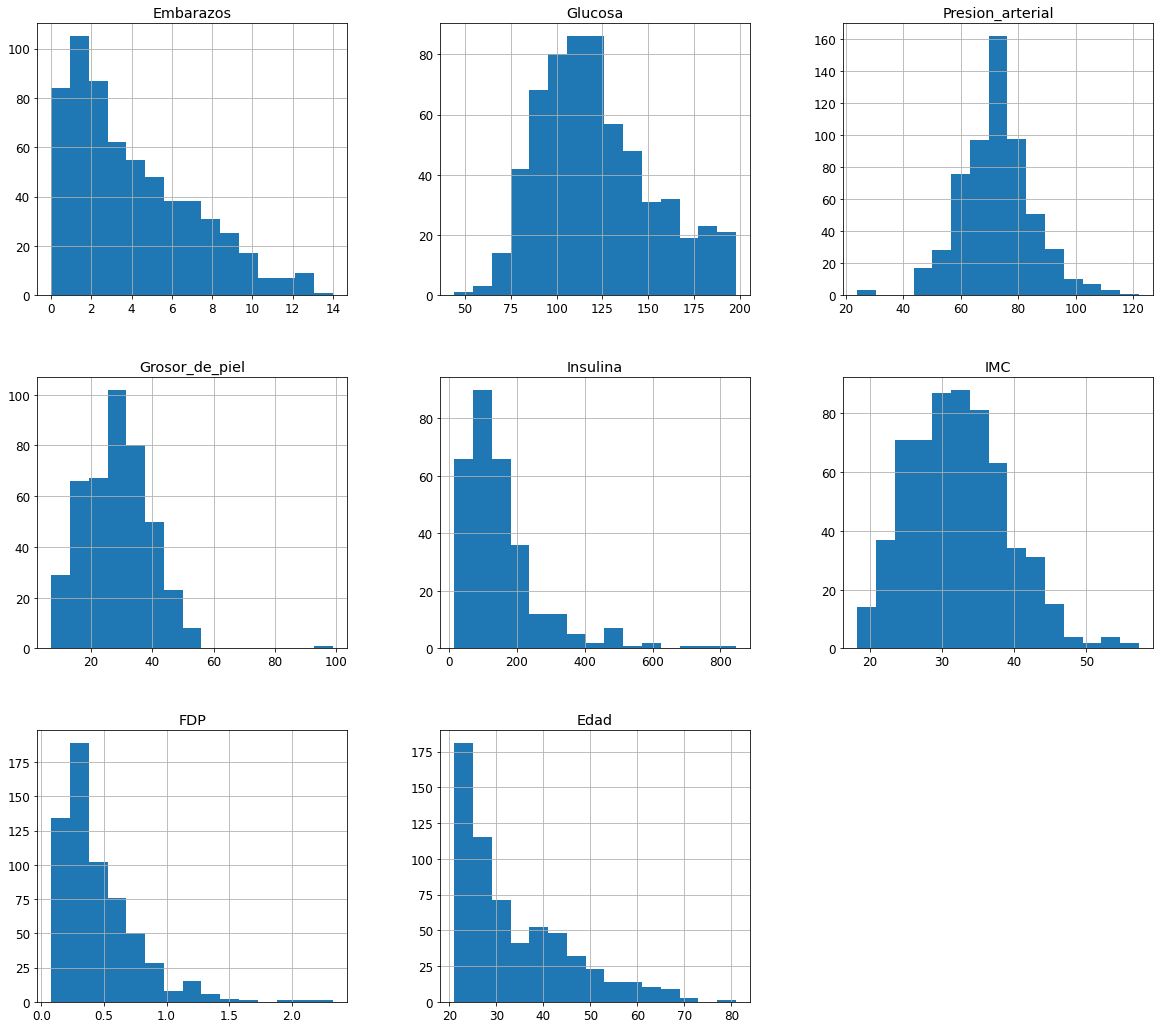

In [903]:
train.hist(bins=15, figsize=(20,18))
plt.show()

#### Identificación de outliers

Mediante los diagramas de caja (Box plots) se determinara la existencia de datos atípicos.

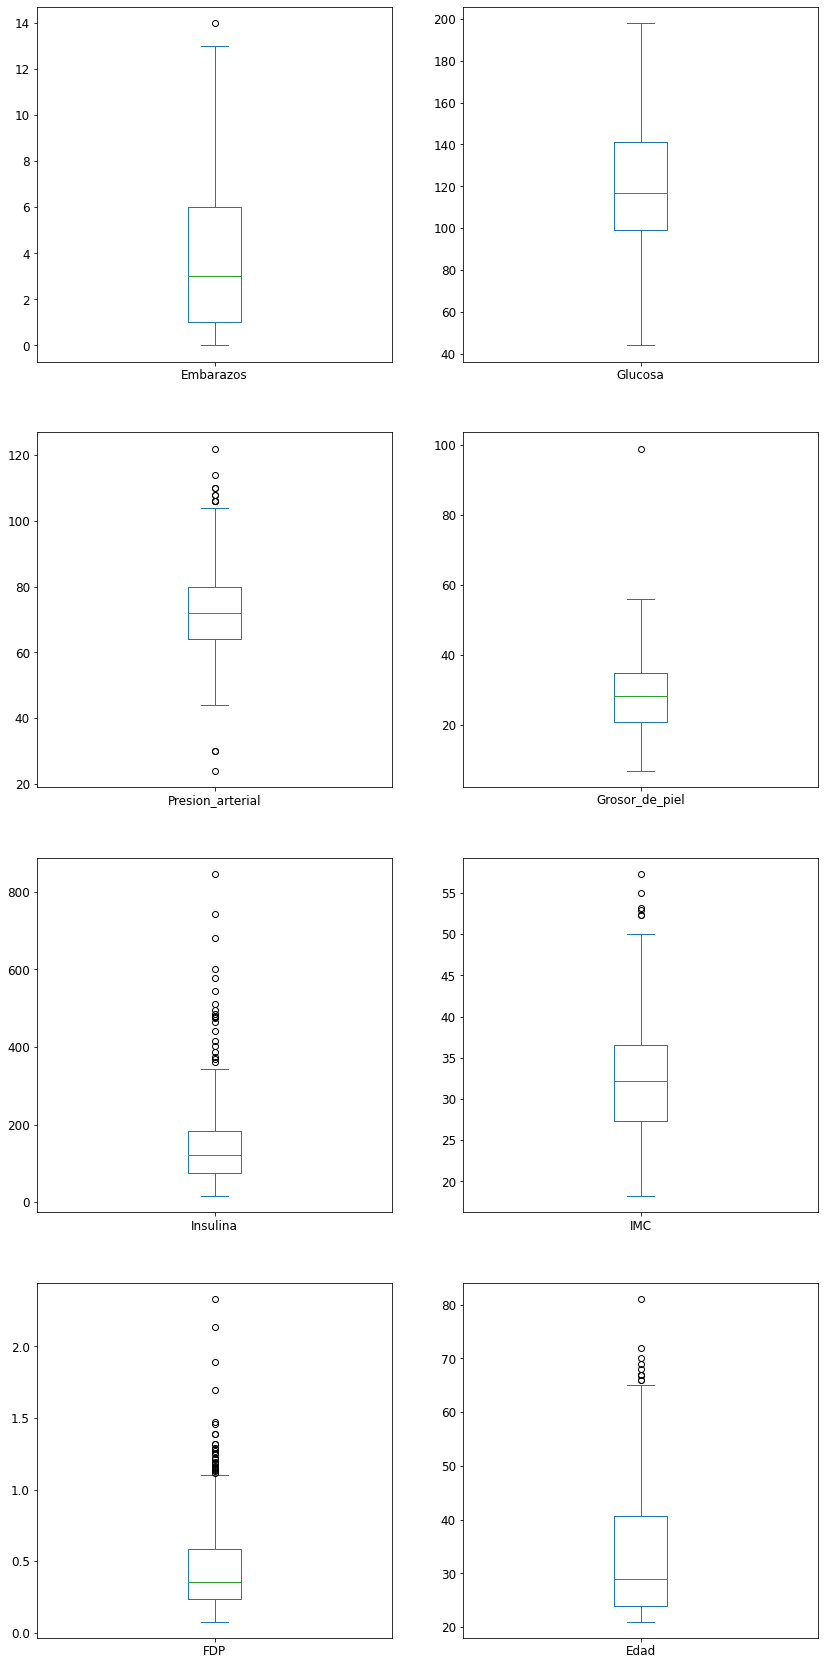

In [904]:
train.plot(kind='box', subplots=True, layout=(4,2), figsize=(14,30))
plt.show()

En general, casi todas las variables del conjunto de entrenamiento presentan al menos un dato atípico a excepción de **Glucosa**. Para tener una cuantificación total de la cantidad de outliers se utiliza el criterio del rango intercuartil (IQR), el cual consiste en determinar que datos son mayores al percentil 75 mas 1.5 veces IQR o menores al percentil 25 menos 1.5 veces IQR.

In [905]:
def outliers(variable):
    Q1 = variable.quantile(0.25)
    
    Q3 = variable.quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower, upper = Q1 - IQR * 1.5, Q3 + IQR * 1.5
    
    outlier = [x for x in variable if x < lower or x > upper]
    return len(outlier)


In [906]:
for variables in variables_pred:
    print('Cantidad de outliers de la variable', 
          variables, outliers(train[variables]))

Cantidad de outliers de la variable Embarazos 1
Cantidad de outliers de la variable Glucosa 0
Cantidad de outliers de la variable Presion_arterial 12
Cantidad de outliers de la variable Grosor_de_piel 1
Cantidad de outliers de la variable Insulina 20
Cantidad de outliers de la variable IMC 6
Cantidad de outliers de la variable FDP 29
Cantidad de outliers de la variable Edad 10


Todas las variables a excepción de **Glucosa** presentan por lo menos un valor atípico.

Además mediante diagramas de caja separados por la variable objetivo **y** es posible ver como es la distribución de los datos de manera aislada para cada uno de los resultados posibles.

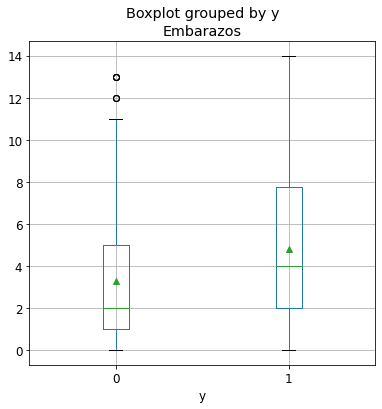

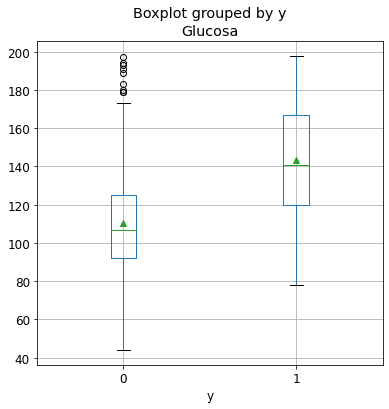

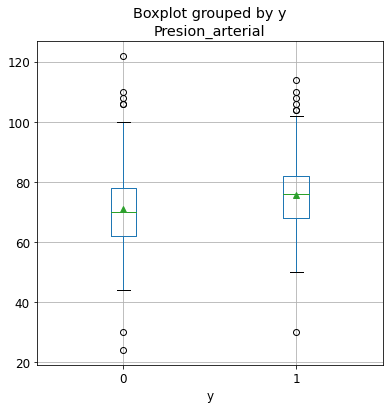

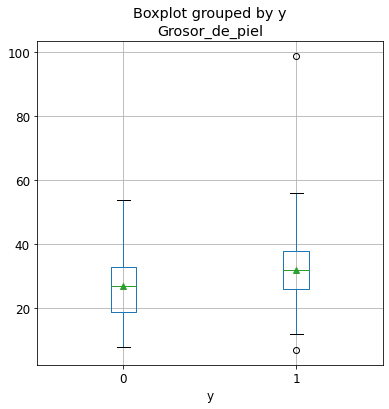

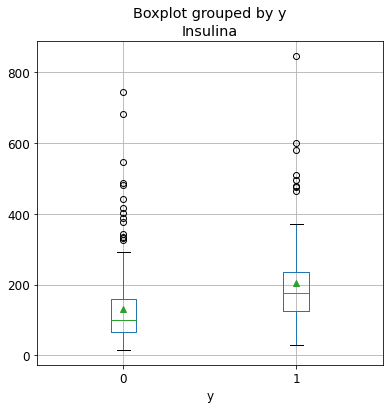

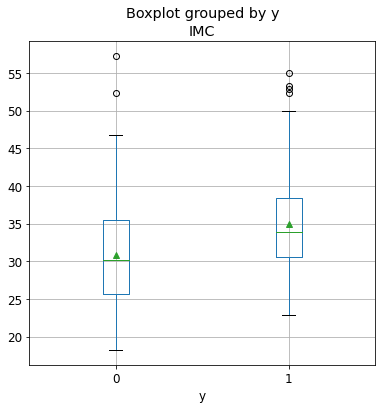

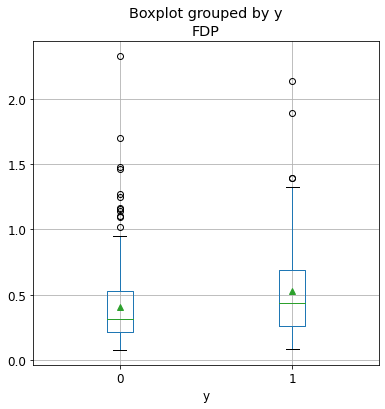

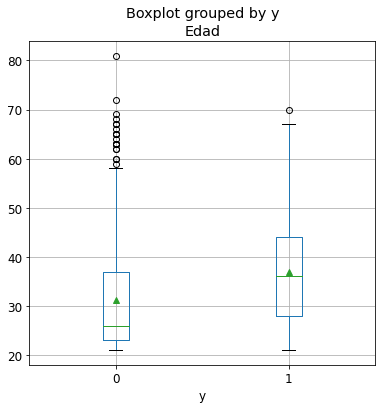

In [907]:
for variable in variables_pred:
    train.boxplot(column = variable, by = 'y', showmeans=True, figsize =(6,6))
    plt.title(variable)
plt.show()

Mientras mas marcada sea la diferencia en la distribución de los datos con respecto a la variable objetivo mejor sera para el modelo, ya que encontrará de manera mas facil patrones que lo diferencian, en caso contrario, al modelo le costará predecir con exactitud. Basándonos en esto último, la variable que presenta la mayor diferencia de distribución de los datos entre las mujeres con diabetes de las demás es la **Glucosa**. 

En relación al resto de variables, en general todas presentan una diferencia en la distribución de los datos, aunque esta es pequeña a simple vista. Igualmente esto se debe tomar con precaución, ya que debido a la aleatoriedad de la división de la data, es posible que estas diferencias puedan no existir en el conjunto de datos completo.

#### Matriz de correlaciones

De la matriz de correlaciones se puede destacar lo siguiente:

- Ninguna variable esta correlacionada de manera negativa.
- Hay solo 3 pares de variables que presentan una correlación positiva relativamente alta (mayor a 0.5).

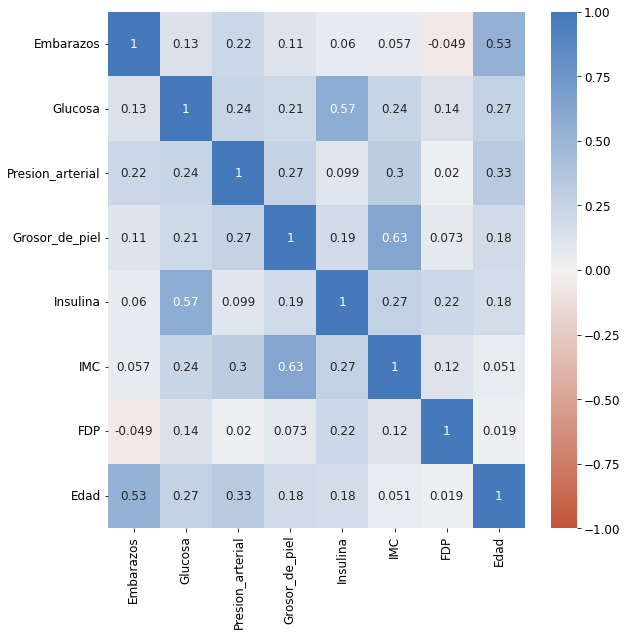

In [908]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(train_X.corr(), vmin=-1, vmax=1, annot=True, 
                 cmap=sns.diverging_palette(20, 250, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

#### Gráfico de dispersión

Se grafican las variables numéricas para verificar visualmente las relaciones que entrega la matriz de correlaciones.

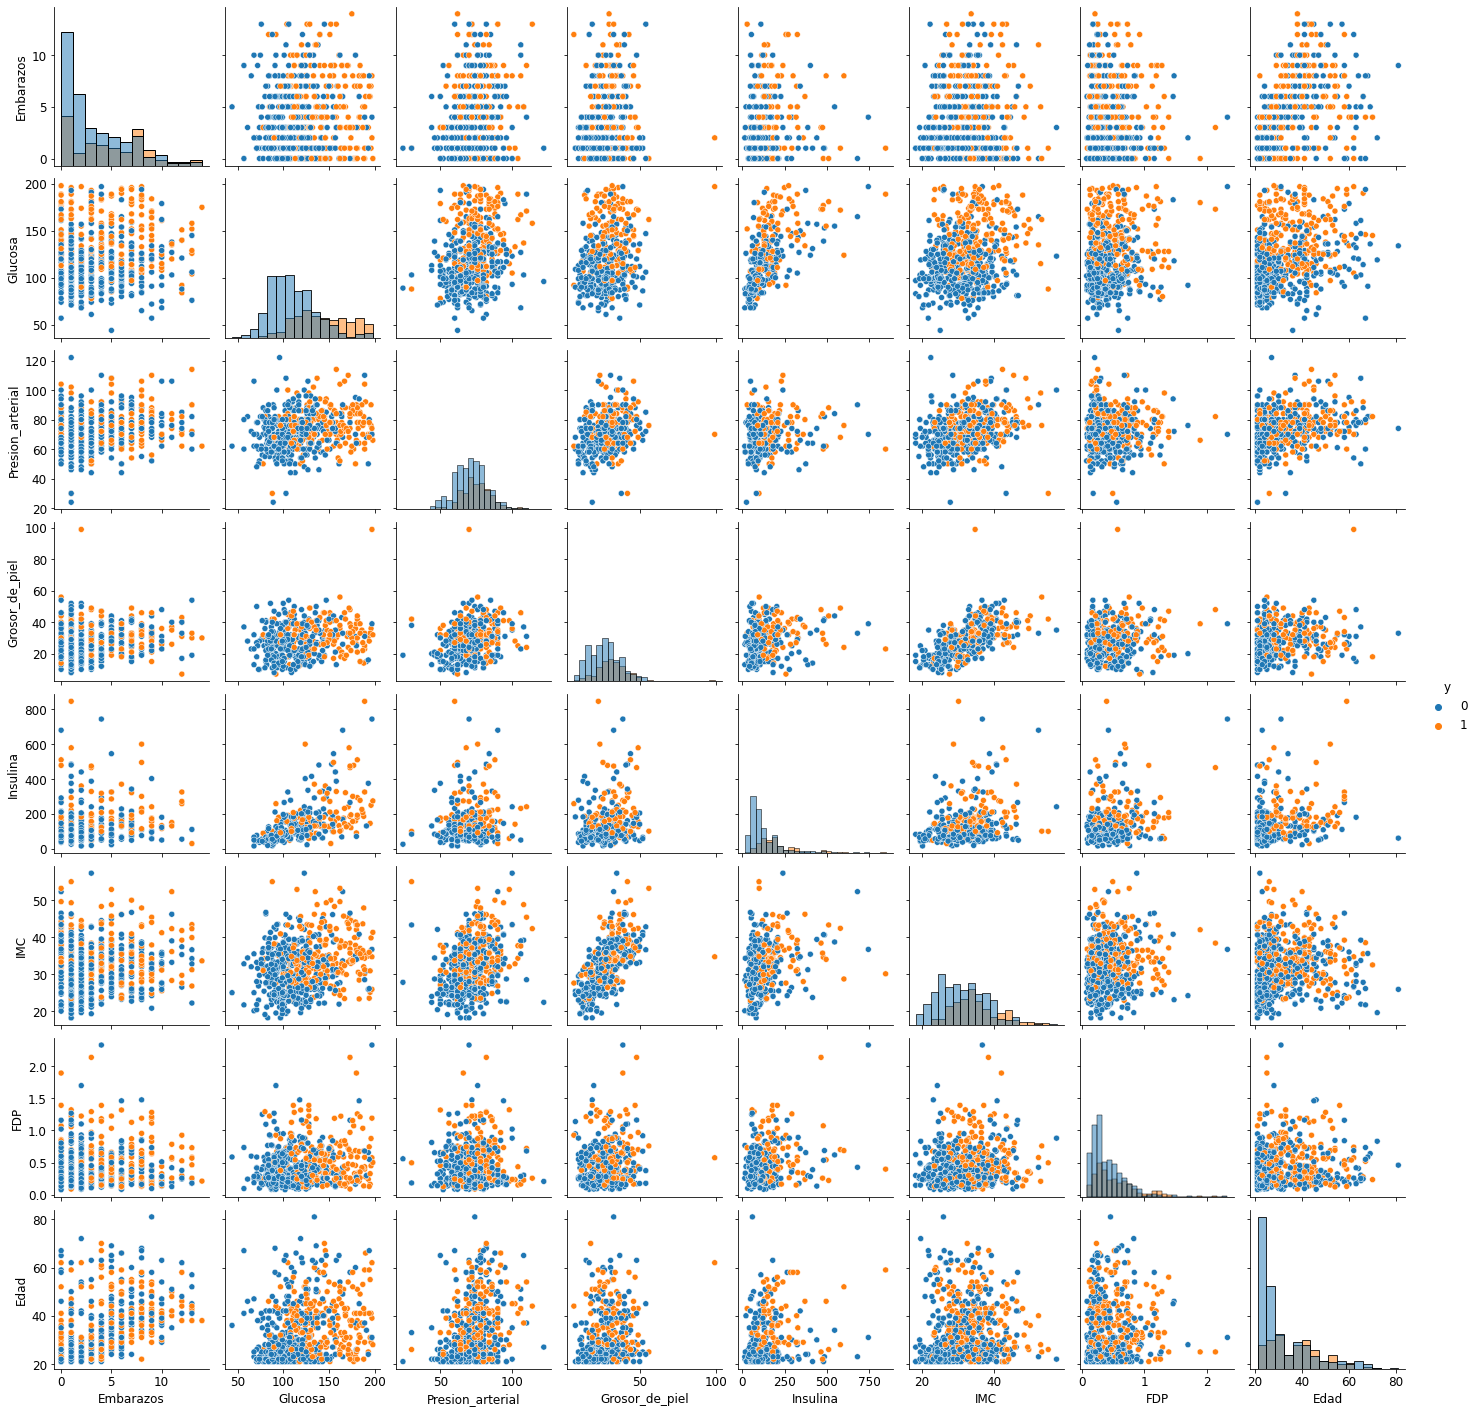

In [909]:
sns.pairplot(train, hue='y', diag_kind = 'hist')

Del gráfico de dispersión se puede ver que existe una tendencia marcada que indica que en los niveles mas altos de glucosa hay más mujeres con diabetes. Por lo que se llega a la misma conclusión que con los diagramas de caja. La variable **Glucosa** a simple vista se considera la más importante a la hora de alimentar un modelo.

## Preparación de datos

### Imputación de datos nulos

Se asume que las personas con similares características deberian poseer datos similares, por ello se utilizará el método de imputación de datos basado en el algoritmo kNN para llenar los datos faltantes, es decir, aquellos que no corresponden a un valor 0.

Se utilizará el valor *n_neighbors* que viene por default asignado en el algoritmo, el cual equivale a 5.

In [1002]:
#Definición del imputer
imputer = KNNImputer()

#Se ajusta el imputer a los datos de entrenamiento y se transforman
imp_train_X = imputer.fit_transform(train_X)
imp_train_X

array([[  0.   , 107.   ,  62.   , ...,  36.6  ,   0.757,  25.   ],
       [  5.   , 123.   ,  74.   , ...,  34.1  ,   0.269,  28.   ],
       [  2.   , 146.   ,  76.   , ...,  38.2  ,   0.329,  29.   ],
       ...,
       [  6.   ,  91.   ,  71.2  , ...,  29.8  ,   0.501,  31.   ],
       [ 10.   ,  68.   , 106.   , ...,  35.5  ,   0.285,  47.   ],
       [  8.   , 151.   ,  78.   , ...,  42.9  ,   0.516,  36.   ]])

A los datos resultantes se les da un formado *Dataframe* para facilitar futuros calculos.

In [1003]:
imp_train_X = pd.DataFrame(imp_train_X, columns = variables_pred, index=train_X.index)
imp_train_X

,Embarazos,Glucosa,Presion_arterial,Grosor_de_piel,Insulina,IMC,FDP,Edad
291,0.0,107.0,62.0,30.0,74.0,36.6,0.757,25.0
652,5.0,123.0,74.0,40.0,77.0,34.1,0.269,28.0
244,2.0,146.0,76.0,35.0,194.0,38.2,0.329,29.0
1,1.0,85.0,66.0,29.0,61.6,26.6,0.351,31.0
633,1.0,128.0,82.0,17.0,183.0,27.5,0.115,22.0
...,...,...,...,...,...,...,...,...
535,4.0,132.0,69.6,28.6,215.2,32.9,0.302,23.0
384,1.0,125.0,70.0,24.0,110.0,24.3,0.221,25.0
533,6.0,91.0,71.2,24.6,59.4,29.8,0.501,31.0
672,10.0,68.0,106.0,23.0,49.0,35.5,0.285,47.0


Con la imputación de datos, no existe un gran cambio en la correlación entre las distintas variables.

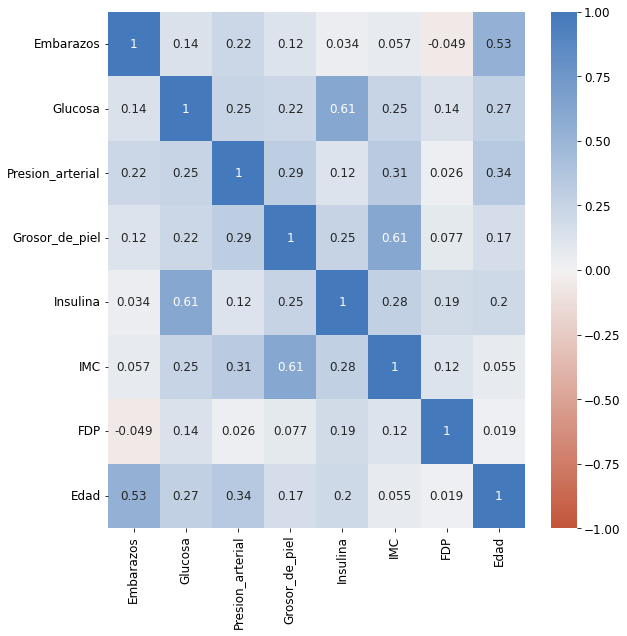

In [1004]:
fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(imp_train_X.corr(), vmin=-1, vmax=1, annot=True, 
                 cmap=sns.diverging_palette(20, 250, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

### Feature engineering

A continuación se generarán nuevas variables a partir de las ya conocidas, además de discretizar algunas:

- Las variables **Edad** y **Embarazos** siempre serán variables enteras, por lo que pueden ser consideradas como variables categoricas.
- Las variables **Glucossa**, **Presión_arterial**, **Insulina** e **IMC** también pueden ser transformadas a variables categoricas mediante distintos criterios predefinidos por la CDC (Centers for Disease Control and Prevention).
- Para el caso de las variables **Grosor_de_piel** y **FDP** no existen criterios o rangos definidos, por lo que se mantendrán sin cambios estas variables.

### Glucosa

Esta variable sera discretizada en base a los rangos especificados por la *CDC* a dos horas de haber realizado el test.
A continuación se presentan los rangos definidos:

- N: Un nivel de glucosa menor a 140mg/dL se considera normal.
- PD: Un nivel de glucosa entre 140mg/dL y 200mg/dL se considera una persona con prediabetes.
- D: Un nivel de glucosa superior a 200mg/dL se considera una persona con diabetes.

In [1005]:
train_copy = imp_train_X.copy()
train_copy['Glucosa_cat'] = pd.cut(train_copy['Glucosa'], 
                               bins = [0., 140., 200., np.inf],
                               labels = ['N', 'PD', 'D'])

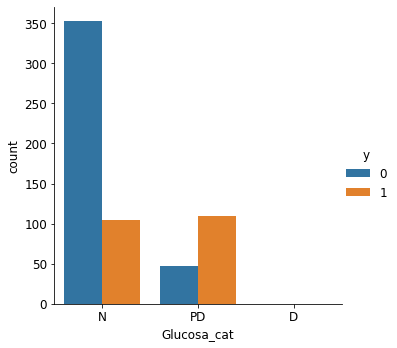

In [1006]:
#se agrega la variable objetivo para poder realizar el gráfico
train_copy['y'] = train_y.copy() 
sns.catplot(x='Glucosa_cat',hue='y',data=train_copy,kind="count")

Del gráfico de barras en primera instancia se aprecia que no hay datos para un nivel de glucosa superior a 200mg/dL (D). Para los rangos inferiores N y PD existe una clara diferencia en la cantidad de mujeres que no tienen diabetes con respecto a las que si tienen, por lo que se debe determinar en que forma es mas eficaz ocuparla, ya sea de manera categórica o numérica.

### Presion_arterial

La presión arterial diastólica mide la presión en las arterias cuando el corazón descansa entre latidos. Se definen tres rangos en base a la información otorgada por la *CDC*.

- N: Menor a 80 se considera normal
- PH:Entre 80 y 89 se considera prehipertensión
- H: mayor a 90 se considera hipertensión

In [1007]:
train_copy['Presion_arterial_cat'] = pd.cut(train_copy['Presion_arterial'], 
                                              bins = [0., 80., 90., np.inf],
                                              labels = ['N', 'PH', 'H'])

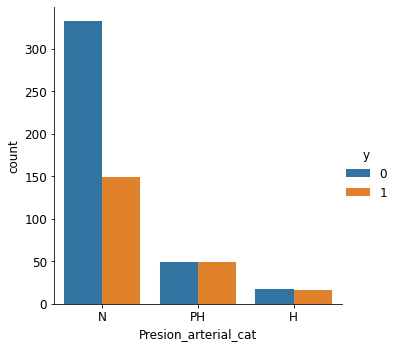

In [1008]:
sns.catplot(x='Presion_arterial_cat',hue='y',data=train_copy,kind="count")

Para los rangos PH y H la cantidad de mujeres con diabetes es casi igual a las que no tienen, solo existen diferencias para el rango menor (N), por lo que no se considera una buena variable para alimentar un modelo.

### Insulina

Los datos provienen de un test de tolerancia a la glucosa con niveles de insulina para evaluar el procesamiento de glucosa y como responde la insulina en el cuerpo. Para este caso solo se consideran dos categorías, por lo que se puede considerar una variable binaria:

- BI: Menor a 166mIU/L se considera un nivel de insulina normal.
- AI: Mayor a 166mIU/L se considera un nivel de insulina alto.

In [1009]:
train_copy['Insulina_bin'] = 'BI'
train_copy.loc[train_X_copy['Insulina'] > 166, 'Insulina_bin'] = 'AI'

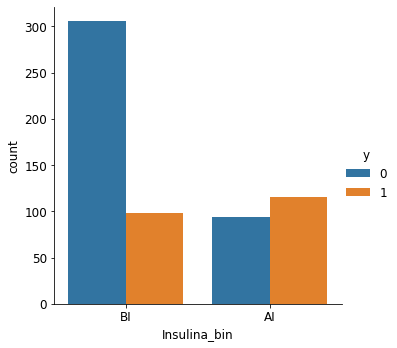

In [1010]:
sns.catplot(x='Insulina_bin',hue='y',data=train_copy,kind="count")

En bajos niveles de insulina hay una gran diferencia entre la cantidad de mujeres con diabetes con respecto a las que no tienen, pero en altos niveles de insulina esta diferencia es bastante pequeña.

### IMC

El índice de masa corporal (IMC) es el ratio entre el peso de una persona y su altura al cuadrado. Los rangos se definen a continuación:

- I: Un IMC menor a 18.5 se considera peso insuficiente.
- N: Un IMC mayor a 18.5 y menor a 24.9 se considera peso normal.
- S: Un IMC mayor a 25 y menor a 29.9 se considera sobrepeso.
- O1: Un IMC mayor a 30 y menor a 34.9 se considera obesidad grado 1.
- O2: Un IMC mayor a 35 y menor a 39.9 se considera obesidad grado 2.
- O3: Un IMC mayor 40 se considera obesidad grado 3.

In [1011]:
train_copy['IMC_cat'] = pd.cut(train_copy['IMC'], 
                               bins = [0., 18.5, 25, 30, 35, 40, np.inf],
                               labels = ['I', 'N', 'S', 'O1', 'O2', 'O3'])

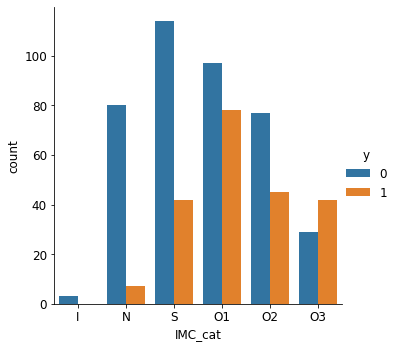

In [1012]:
sns.catplot(x='IMC_cat',hue='y',data=train_copy,kind="count")

En teoría, mientras mayor sea el IMC mayor es el riesgo de tener diabetes, en este caso se cumple la teoría pero no a cabalidad, aun así sera interesante considerar el IMC a nivel categórico ya que presenta cierto patrón.

### Escalamiento de datos

Debido a la cantidad de outliers existentes en algunas variables y la diferencia en la unidad de medida de estas, es necesario escalar los datos. Para ello se utilizará el método de estandarización robusta, el cual corresponde al valor de la variable menos la mediana, dividido por la diferencia entre los percentiles 75 y 25.

En primer lugar se usará el criterio ANOVA F-test para comprobar la independencia de las variables de entrada numéricas con respecto a la variable objetivo, de esta manera se podrá determinar si vale la pena discretizar las variables anteriormente mencionadas. 

In [1013]:
#Se define el método para escalar las variables numéricas
scaler = RobustScaler()

#Se ajusta le método
scaler.fit(imp_train_X)

#Se escalan las variables
sca_imp_train_X = scaler.transform(imp_train_X)

### Variables numéricas

Embarazos 31.403236867447102
Glucosa 211.47690849942697
Presion_arterial 23.73125110361842
Grosor_de_piel 39.95197977904533
Insulina 67.99707682531565
IMC 56.03957602255152
FDP 24.95924219299133
Edad 35.09336251473738


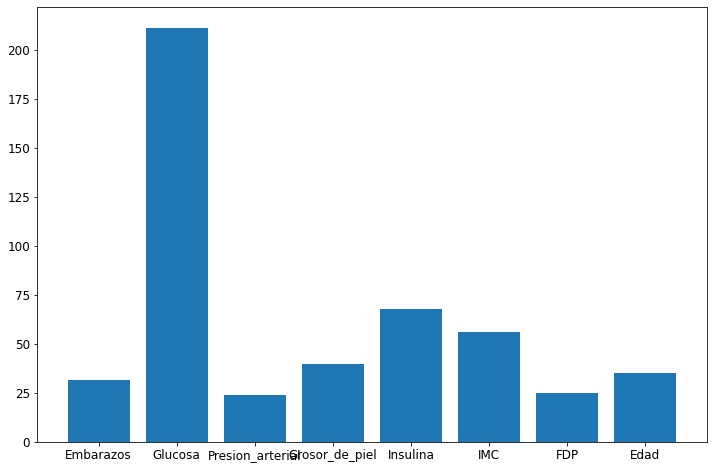

In [1014]:
#Definiendo el método a utilizar
sv_num = SelectKBest(score_func = f_classif, k='all')

#Ajustar y transformar las variables de entrenamiento
sv_num.fit_transform(sca_imp_train_X, train_y)

#Lista de scores
for i, variable in zip((range(len(sv_num.scores_))), variables_pred):
    print(variable, sv_num.scores_[i])

#Graficar scores
plt.figure(figsize = (12,8))
plt.bar([score for score in variables_pred], sv_num.scores_)
plt.show()

Según el criterio ANOVA F-test, indica que la variable numérica mas relevante es **Glucosa** por lejos, seguido de **Insulina**. Por lo tanto, discretizar la variable **Glucosa** no parece ser beneficioso. Igualmente se determinara su relevancia con respecto a las demás variables discretizadas mediante el criterio Chi-cuadrado test que mide la dependencia entre variables estocásticas, por lo que sirve para determinar que variables tienen más probabilidades de ser independientes con respecto a la variable objetivo.

### Variables categoricas 

Primero se genera una clase que sea capaz de transformar aquellas variables numéricas en categoricas.

In [1016]:
class num_to_cat(BaseEstimator, TransformerMixin):
    def __init__(self, feature_name):
        self.feature_name = feature_name
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = pd.DataFrame(X.copy(), columns = variables_pred)
        for variable in self.feature_name:
            if variable == 'Glucosa':
                X_['Glucosa_cat'] = pd.cut(X_[variable], 
                               bins = [0., 140., 200., np.inf],
                               labels = ['N', 'PD', 'D'])
                X_ = X_.drop([variable], axis = 1)
                
            elif variable == 'Presion_arterial':
                X_['Presion_arterial_cat'] = pd.cut(X_[variable], 
                                              bins = [0., 80., 90., np.inf],
                                              labels = ['N', 'PH', 'H'])
                X_ = X_.drop([variable], axis = 1)
                
            elif variable == 'Insulina':
                X_['Insulina_bin'] = 'BI'
                X_.loc[X_[variable] > 166, 'Insulina_bin'] = 'AI'
                X_ = X_.drop([variable], axis = 1)
                
            elif variable == 'IMC':
                X_['IMC_cat'] = pd.cut(X_[variable], 
                                bins = [0., 18.5, 25, 30, 35, 40, np.inf],
                                labels = ['I', 'N', 'S', 'O1', 'O2', 'O3'])
                X_ = X_.drop([variable], axis = 1)
        
        return X_

Luego se ocupa el método ColumnTransform para aplicar las transformaciones correspondientes a las variables, en este caso corresponden a las variables que serán discretizadas.

Se aplica el método OrdinalEncoder para las variables discretizadas, para luego ser usadas en el método SelectKBest.

In [1017]:
#Se definen las variables categoricas
variables_cat = ['Embarazos', 'Glucosa_cat', 'Presion_arterial_cat', 'Insulina_bin', 'IMC_cat', 'Edad']

#Se define el método para las variables categoricas
oe = OrdinalEncoder()

#Se definen las transformaciones a las variables
transformer = ColumnTransformer([('cat', oe, variables_cat)])

#Se define el pipeline
transformer_pipeline = Pipeline([('imputer', imputer),
                               ('discretizar', num_to_cat(variables_pred)),
                               ('transformer', transformer)
                       ])

#Se aplica el procesamiento completo de los datos
trans_train_X = transformer_pipeline.fit_transform(train_X)
trans_train_X.shape

(614, 6)

Como se puede apreciar en el siguiente gráfico, practicamente la única variable que es relevante considerar como categórica según el criterio de Chi-cuadrado test es la **Edad**, por lo tanto, el resto de variables seran consideradas como numéricas.

Embarazos 83.73067350066302
Glucosa_cat 84.2518694584232
Presion_arterial_cat 0.7428451603120778
Insulina_bin 19.976885814749703
IMC_cat 1.5083463650516307
Edad 383.41569196361644


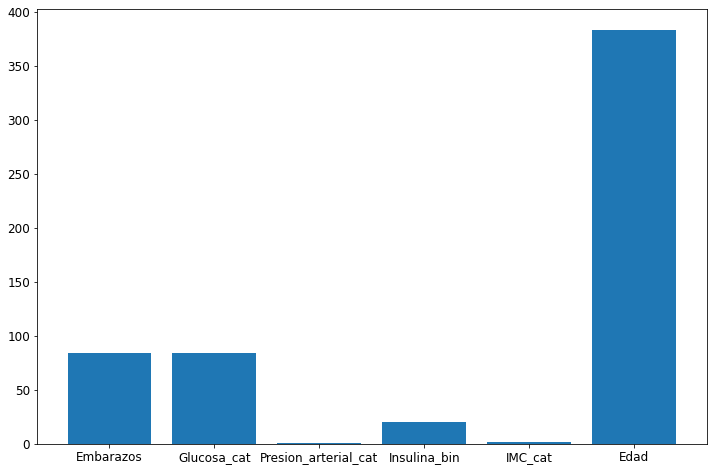

In [1019]:
#Definiendo el método a utilizar
sv_cat = SelectKBest(score_func = chi2, k='all')

#Ajustar y transformar las variables de entrenamiento
sv_cat.fit_transform(trans_train_X, train_y)

#Lista de scores
for i, variable in zip((range(len(sv_cat.scores_))), variables_cat):
    print(variable, sv_cat.scores_[i])

#Graficar scores
plt.figure(figsize = (12,8))
plt.bar([score for score in variables_cat], sv_cat.scores_)
plt.show()

Como las variables no serán discretizadas, se genera una nueva función para automatizar el proceso de transformación de las variables, en donde para la variable **Edad** se usará el método OneHotEncoder.

In [1020]:
def transformer_var(train_X, test_X, var_num, var_cat):
    #Se define el imputer
    imputer = KNNImputer()
    
    #Se ajusta el imputer y se transforman los datos
    imp_train_X = imputer.fit_transform(train_X)
    
    #Se transforman los datos de prueba
    imp_test_X = imputer.transform(test_X)
    
    #Se transforma a data frame para poder aplicar el método columntransform
    imp_train_X = pd.DataFrame(imp_train_X, columns = variables_pred, index=train_X.index)
    imp_test_X = pd.DataFrame(imp_test_X, columns = variables_pred, index=test_X.index)
    
    #Se define el robust scaler
    scaler = RobustScaler()
    
    #Se define el one hot encoder
    ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
    
    #Se define el transformer
    transformer = ColumnTransformer([('num', scaler, var_num),
                                     ('cat', ohe, var_cat)])
    
    #Se ajusta el transformer y se transforman los datos ya imputados
    trans_train_X = transformer.fit_transform(imp_train_X)
    
    #Se transforman los datos de prueba
    trans_test_X = transformer.transform(imp_test_X)
    
    return trans_train_X, trans_test_X

In [1022]:
variables_num = ['Embarazos', 'Glucosa', 'Presion_arterial', 'Grosor_de_piel', 'Insulina', 'IMC', 'FDP']
variables_cat = ['Edad']
trans_train_X, trans_test_X = transform_var(train_X, test_X, variables_num, variables_cat)
print((trans_train_X.shape), (trans_test_X.shape))

(614, 59) (154, 59)


## Entrenamiento y selección del modelo

A continuación se comparan distintos modelos mediante el método cross_val_score, el cual estimará un promedio del accuracy utilizando la validación cruzada solo para los datos de entrenamiento.

### Validación de modelos

Se utiliza la función cross_val_score para evaluar los modelos mediante la validación cruzada según el **accuracy** que obtenga cada uno. 

En el proceso de validación los datos son divididos en 10 secciones, en donde 9 son usadas para entrenar el modelo y 1 para validarlo, este proceso se repite 10 veces hasta que todas las secciones de datos hayan sido consideradas para validar el modelo, además este proceso es repetido 3 veces, por lo que cada modelo sera entrenado un total de 30 veces.

In [1023]:
#Se define la función para validar cada modelo
def validar_modelo(modelo, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(modelo, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

### Definición de modelos

Los modelos a evaluar son 6 y son mecionados a continuación:

- Decision Tree
- Random Forest
- XGBOOST
- Regresión Logística
- Support Vector Machine (SVM)
- k-Nearest Neighbors

Los modelos seran definidos con hyper-parámetros por default. 

In [1024]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=1)

# Random Forest
rf = RandomForestClassifier(random_state=1)
#class_weight="balanced"
# XGBOOST
xgb = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss',
                         random_state=1) 

# Regresión Logística
lr = LogisticRegression()

# Support Vector Machine (SVM)
svc = SVC()

# k-Nearest Neighbors
knn = KNeighborsClassifier()

In [1025]:
nombres = []
accuracy = []

modelos = {'Decision Tree': dt, 'Random Forest': rf, 'XGBOOST': xgb, 
           'Regresión logística': lr, 'Support Vector Clasification': svc,
           'K-Nearest Neighbors': knn}

for nombre, modelo in modelos.items():
    
    scores = validar_modelo(modelo, trans_train_X, train_y)
    
    accuracy.append(scores)
    
    nombres.append(nombre)
    
    print('El modelo', nombre, 'tiene un accuracy de %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))

El modelo Decision Tree tiene un accuracy de 70.477 (5.214)
El modelo Random Forest tiene un accuracy de 76.763 (5.234)
El modelo XGBOOST tiene un accuracy de 75.083 (4.125)
El modelo Regresión logística tiene un accuracy de 77.911 (4.916)
El modelo Support Vector Clasification tiene un accuracy de 76.609 (5.415)
El modelo K-Nearest Neighbors tiene un accuracy de 73.508 (4.600)


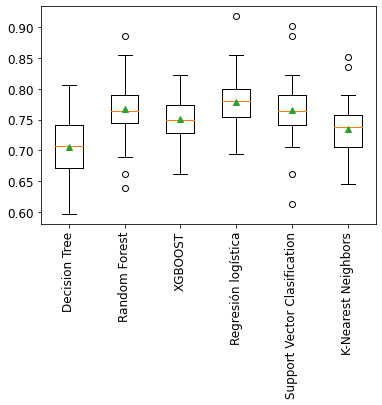

In [1026]:
plt.boxplot(accuracy, labels = nombres, showmeans=True)
plt.xticks(rotation=90)
plt.show()

De los 6 modelos propuestos, el que posee el mayor rendimiento corresponde a la Regresión logística, pero igualmente se van a optimizar y evaluar los 2 modelos que lo siguen (Random Forest y Support Vector Machine respectivamente), ya que si bien en primera instancia se tomo como métrica de selección el **accuracy**, se debe tener presente que la métrica **recall** también se considera importante en este caso, ya que, el objetivo principal consiste en determinar si la persona tiene o no diabetes, por lo tanto se deben minimizar en gran medida los falsos negativos, es decir, aquellos diagnósticos que indican que la persona no tiene diabetes cuando en verdad si la tiene.

### Optimización y evaluación de modelos

Ahora se optimizarán y evaluarán los hyper-parámetros de los 3 modelos seleccionados mediante el método GridSearchCV.

In [1027]:
def metricas_evaluacion(test_y, pred_y):
    accuracy = round(accuracy_score(test_y, pred_y),4)*100
    recall = round(recall_score(test_y, pred_y),4)*100
    precision = round(precision_score(test_y, pred_y),4)*100
    
    return accuracy, recall, precision

#### Regresión Logística

##### Optimización

In [1028]:
#Hyper-parámetros Regresión logística
param_lr = [{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
              'penalty': ['l1', 'l2'],
              'C': [1000, 100, 10, 1, 0.1, 0.01]}]

#Aplicación del método GridSearchCV
grid_search_lr = GridSearchCV(lr, param_lr, n_jobs = -1, cv=10, scoring='accuracy')
grid_search_lr.fit(trans_train_X, train_y)
print(f" Optimizando hyper-parámetros se obtiene un accuracy: {round(grid_search_lr.best_score_,4)*100}% usando {grid_search_lr.best_params_}")

#Guardando el modelo con los mejores hyper-parámetros
best_lr = grid_search_lr.best_estimator_

 Optimizando hyper-parámetros se obtiene un accuracy: 78.0% usando {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


##### Evaluación 

In [1029]:
#Se pronóstican los y en base al conjunto de prueba
lr_pred_y = best_lr.predict(trans_test_X)

#Se evalúa el modelo
accuracy_lr, recall_lr, precision_lr = metricas_evaluacion(test_y, lr_pred_y)

#### Random Forest

##### Optimización 

In [1030]:
#Hyper-parámetros Random Forest
param_rf = [{'n_estimators': [100, 150, 200, 250, 300], 
              'max_features': ['auto', 'sqrt'], 
              'min_samples_leaf': [1, 3, 5, 7, 9]}]

#Aplicación del método GridSearchCV
grid_search_rf = GridSearchCV(rf, param_rf, n_jobs = -1, cv=10, scoring='accuracy')
grid_search_rf.fit(trans_train_X, train_y)
print(f" Optimizando hyper-parámetros se obtiene un accuracy: {round(grid_search_rf.best_score_,4)*100}% usando {grid_search_rf.best_params_}")

#Guardando el modelo con los mejores hyper-parámetros
best_rf = grid_search_rf.best_estimator_

 Optimizando hyper-parámetros se obtiene un accuracy: 77.19% usando {'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}


#####  Evaluación

In [1031]:
#Se pronóstican los y en base al conjunto de prueba
rf_pred_y = best_rf.predict(trans_test_X)

#Se evalúa el modelo
accuracy_rf, recall_rf, precision_rf = metricas_evaluacion(test_y, rf_pred_y)

##### Support Vector Machine 

##### Optimización 

In [1032]:
#Hyper-parámetros Support Vector Machine
param_svc = [{'kernel': ['linear'], 
              'C': [0.1, 1, 10, 20, 100, 200, 1000, 2000]},
             {'kernel': ['rbf'], 
              'C': [0.1, 1, 10, 20, 100, 200, 1000, 2000],
              'gamma': [0.001, 0.01, 0.1, 1]}]

#Aplicación del método GridSearchCV
grid_search_svc = GridSearchCV(svc, param_svc, n_jobs = -1, cv=10, scoring='accuracy')
grid_search_svc.fit(trans_train_X, train_y)
print(f" Optimizando hyper-parámetros se obtiene un accuracy: {round(grid_search_svc.best_score_,4)*100}% usando {grid_search_svc.best_params_}")

#Guardando el modelo con los mejores hyper-parámetros
best_svc = grid_search_svc.best_estimator_

 Optimizando hyper-parámetros se obtiene un accuracy: 78.33% usando {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}


##### Evaluación 

In [1033]:
#Se pronóstican los y en base al conjunto de prueba
svc_pred_y = best_svc.predict(trans_test_X)

#Se evalúa el modelo
accuracy_svc, recall_svc, precision_svc = metricas_evaluacion(test_y, svc_pred_y)

#### Comparación de métricas 

In [1034]:
metricas = {'Modelo': ['Regresión Logística', 'Random Forest', 'Support Vector Machine'],
            'Accuracy': [accuracy_lr, accuracy_rf, accuracy_svc],
            'Recall': [recall_lr, recall_rf, recall_svc],
            'Precision': [precision_lr, precision_rf, precision_svc]}

pd.DataFrame(metricas, columns = ['Modelo', 'Accuracy', 'Recall', 'Precision'])

,Modelo,Accuracy,Recall,Precision
0,Regresión Logística,76.62,61.11,68.75
1,Random Forest,72.08,62.96,59.65
2,Support Vector Machine,75.97,57.41,68.89


Por ahora el modelo de *Regresión Logística* presenta métricas muy similares al *Support Vector Machine*, por esta razón se usara otra metréca para tomar una decisión sobre cual modelo usar.

### Curva ROC

La curva ROC es otra forma de determinar cual modelo tiene un mejor desempeño, el cual gráfica la tasa de los verdaderos positivos versus la tasa de los falsos positivos.

Para el caso del modelo *Support Vector Machine* se utiliza el método *decision_function*, ya que este no entrega una probabilidad de pertenencia a cada clase.

In [1035]:
#Se define la probabilidad de que y pertenezca a la clase 1 para la regresión logística
y_scores_lr = best_lr.predict_proba(trans_test_X)

#Se define la probabilidad de que y pertenezca a la clase 1 para el random forest
y_scores_rf = best_rf.predict_proba(trans_test_X)

#Se define la probabilidad mediante el método decision function para Support Vector Machine
y_scores_svc = best_svc.decision_function(trans_test_X)

fpr_lr, tpr_lr, umbral_lr = roc_curve(test_y, y_scores_lr[:, 1])
fpr_rf, tpr_rf, umbral_rf = roc_curve(test_y, y_scores_rf[:, 1])
fpr_svc, tpr_svc, umbral_svc = roc_curve(test_y, y_scores_svc)

Luego de determinar los puntajes de cada modelo, se realiza el gráfico correspondiente.

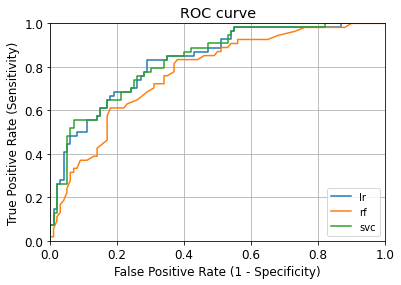

In [1036]:
plt.plot(fpr_lr, tpr_lr, label='lr')
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_svc, tpr_svc, label="svc")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

Se puede apreciar que la curva de la *Regresión logística* es muy similar a la del *Support Vector Machine*, por lo mismo se calcula el área bajo la curva para determinar cual es mejor.

In [1037]:
auc_lr = roc_auc_score(test_y, y_scores_lr[:, 1])
auc_rf = roc_auc_score(test_y, y_scores_rf[:, 1])
auc_svc = roc_auc_score(test_y, y_scores_svc)

print('AUC Regresión logística: %.3f' % auc_lr)
print('AUC Random Forest: %.3f' % auc_rf)
print('AUC Support Vector Machine: %.3f' % auc_svc)

AUC Regresión logística: 0.830
AUC Random Forest: 0.774
AUC Support Vector Machine: 0.831


En este caso en particular ambos modelos (*Regresión Logística* y *Support Vector Machine*) tiene un mismo AUC, en consecuencia, ambos modelos tienen un desempeño similar en datos desconocidos basándose en la data de entrenamiento dada. Finalmente el modelo escogido es la *Regresión Logística*, ya que presenta un mejor **Recall**.

Para tener una mejor visualización de los resultados que genera el modelo en el conjunto de prueba se genera la matriz de confusión para el modelo seleccionado.

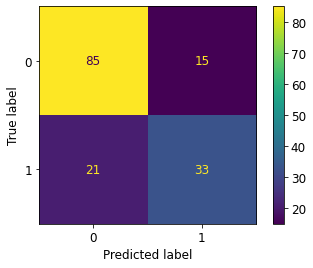

In [1038]:
conf_mat = confusion_matrix(test_y, lr_pred_y)
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat)
conf_mat_display.plot()

De esta matriz y en base al conjunto de prueba se puede concluir que de las 54 mujeres diagnósticadas con diabetes solo 33 fueron pronósticadas correctamente, por lo que 21 de ellas no serian tratadas, lo que agravaría su salud en el mediano plazo si siguen manteniendo su estilo de vida. Por otra parte, de las 48 mujeres pronósticadas con diabetes, existen 15 que en verdad no tienen diabetes, lo que no es bueno, ya que estarian siendo tratadas con medicamentos, cuando en verdad no los necesitan, perjudicando su salud.

Debido a lo anteriormente mencionado, se utiliza el estadístio J de Youden, con el propósito de encontrar el mejor umbral que maximice el **Recall** y minimice la tasa de falsos positivos descrita en la curva ROC.

In [866]:
#Se obtiene el mejor umbral
J = tpr_lr - fpr_lr
indice_mejor_umbral = np.argmax(J)
mejor_umbral = umbral_lr[indice_mejor_umbral]
print('Mejor umbral: %f' % (mejor_umbral))

#Se obtienen los mejores rendimientos en base al umbral determinado
print("Tasa de verdaderos positivos en este umbral:", tpr_lr[indice_mejor_umbral])
print("Tasa de falsos positivos en este umbral:", fpr_lr[indice_mejor_umbral])

Mejor umbral: 0.340195
Tasa de verdaderos positivos en este umbral: 0.8333333333333334
Tasa de falsos positivos en este umbral: 0.29


De esta forma con un umbral de 0.34 se logra aumentar la tasa de verdaderos positivos (**Recall**) de 61.11% a un 83.33%. Pero ahora se debe comparar la variación de la tasa de falsos positivos con respecto al umbral de 0.5 y como varía la métrica precisión.

In [873]:
#Se determina la tasa de falsos positivos para compararla
fpr_inicial = fpr_lr[np.argmax(tpr_lr >= 0.6111)]
fpr_inicial

0.15

La tasa de falsos positivos con este umbral casi se duplica, pasando de 15% a 29% lo que no es bueno para el modelo, ya que ahora existirán mas casos en donde la mujer sea diagnósticada con diabetes cuando en verdad no la tiene.

Ahora se determinara la métrica precisión en base a este nuevo umbral para concluir si es factible el uso del modelo bajo este nuevo condicionamiento, para ello se realizará el gráfico de **Recall vs Precision**.

### Recall vs Precision

In [884]:
#Se calculan las métricas y los umbrales correspondientes
precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores_lr[:, 1])

Luego se gráfican las métricas **Recall** y **Precision** para cada umbral.

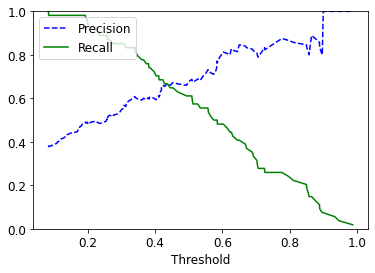

In [878]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [883]:
#Se obtiene la métrica precision en base al mejor umbral calculado
precision_lr_mu = precisions[np.argmax(thresholds == mejor_umbral)]
precision_lr_mu

0.6081081081081081

Se obtiene una **Precision** de un 60.81% para un **Recall** de un 83.34%. Mientras que la métrica **Recall** aumenta en un 22.23%, por el contrario, la métrica **Precision** disminuye en un 7.94%, pasando de 68.75% a 60.81%, el cual vendría a ser el trade-off de aumentar la primera.

## Conclusiones

Si bien el modelo seleccionado el cual corresponde a la *Regresión Logística* presenta un **Accuracy** de un 76.62% lo que se considera aceptable, por el contrario, las métricas **Recall** y **Precision** no son buenas, por lo que existen muchos casos en los que el diagnóstico será erróneo, lo que provocará un empeoramiento en la salud de las mujeres mal diagnosticadas, ya sea por no ser tratadas o por darles un tratamiento que no corresponde a su salud.

Además la modificación del umbral mejora la métrica **Recall** a cambio de aumentar la tasa de falsos positivos, lo que implica una reducción de la **Precision**, lo que de todas formas no es bueno, a menos que el tratamiento para la diabetes sea un cambio en el estilo de vida (es decir, un cambio en la dieta y dejar el sedentarismo), solo en ese caso este umbral sería eficaz, ya que no existirian efectos secundarios al aplicar el tratamiento, pero en general el tratamiento a los pacientes consiste en la administración de distintos medicamentos que si tienen efectos secundarios.

Por lo anterior mencionado se recomienda lo siguiente:

- Obtener más datos para las variables o recopilar datos de nuevas variables para ajustar de mejor forma el modelo.
- Utilizar modelos más potentes que los vistos o métodos de conjunto (ensemble) como *Super Learner*.
- Agregar nuevas variables no vistas en base a la *Feature Engineering*

Todo esto con el fin de mejorar las métricas obtenidas.

Por último, cabe recalcar que idealmente la muestra debe ser lo mas representativa posible de la población, ya que, aunque se recopilen mas datos, esto no asegura que sean representativos, lo que conlleva a obtener malos pronósticos para datos nuevos que el modelo no ha analizado con anterioridad.

In [1039]:
import session_info
session_info.show()